In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Load the music data
df = pd.read_csv('all.csv')

print(f"Total songs: {len(df)}")
print(f"Total unique artists: {df['Artist'].nunique()}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Total songs: 2223
Total unique artists: 863
Columns: ['#', 'Song', 'Artist', 'Popularity', 'BPM', 'Genres', 'Album', 'Album Date', 'Time', 'Dance', 'Energy', 'Acoustic', 'Instrumental', 'Happy', 'Speech', 'Live', 'Loud (Db)', 'Key', 'Time Signature', 'Added At', 'Spotify Track Id', 'Camelot', 'ISRC']

First few rows:


,#,Song,Artist,Popularity,BPM,Genres,Album,Album Date,Time,Dance,...,Happy,Speech,Live,Loud (Db),Key,Time Signature,Added At,Spotify Track Id,Camelot,ISRC
0,1,Gabriel Ratchet,Deca,41,82,jazz rap,The Ocean,2013-09-23,03:11,68,...,76,30,10,-5,G Major,4,2025-08-03,4uQjhQYQyVZBKDtve537qZ,9B,TCABQ1315888
1,2,Lifestylez Ov Da Poor & Dangerous,Big L,45,85,"east coast hip hop, old school hip hop, hardco...",Lifestylez Ov Da Poor & Dangerous,1995-03-28,03:21,68,...,40,30,0,-9,D#/E♭ Minor,4,2025-08-03,5GseQckHgP7uWyaiCd5ZW3,2A,USSM10022975
2,3,Danger Zone,Big L,42,171,"east coast hip hop, old school hip hop, hardco...",Lifestylez Ov Da Poor & Dangerous,1995-03-28,03:36,52,...,34,30,20,-11,G Major,4,2025-08-03,0kU9oWqYnPeqEca3x2auV9,9B,USSM10022974
3,4,Hive (feat. Vince Staples & Casey Veggies),"Earl Sweatshirt,Vince Staples,Casey Veggies",55,145,"experimental hip hop, alternative hip hop,",Doris,2013-08-16,04:37,62,...,78,50,10,-7,C♯/D♭ Major,4,2025-08-03,6JKoTnberZoBgUuxa6l4Kh,3B,USQX91301103
4,5,King Kunta,Kendrick Lamar,73,107,"hip hop, west coast hip hop",To Pimp A Butterfly,2015-03-16,03:54,88,...,49,10,10,-5,F#/G♭ Minor,4,2025-08-03,0N3W5peJUQtI4eyR6GJT5O,11A,USUM71502494


In [2]:
## remove the album called Bach Study Music, since it has bad data quality
df = df[df['Album'] != 'Bach Study Music']

In [6]:
# Artist Analysis
print("ARTIST ANALYSIS")
print("=" * 50)

# Use primary artist name before any comma (e.g., "Artist1, Artist2" -> "Artist1")
df['PrimaryArtist'] = df['Artist'].astype(str).str.split(',').str[0].str.strip()

# Top 20 most frequent primary artists
print("Top 20 Artists by Song Count:")
artist_counts = df['PrimaryArtist'].value_counts().head(20)
print(artist_counts)

# Display all unique primary artists (first 100)
unique_primary = df['PrimaryArtist'].nunique()
print(f"\nAll Artists in Your Collection (showing first 100 of {unique_primary}):")
all_artists = sorted(df['PrimaryArtist'].unique())
for i, artist in enumerate(all_artists[:100], 1):
    print(f"{i:3d}. {artist}")

if len(all_artists) > 100:
    print(f"... and {len(all_artists) - 100} more artists")

ARTIST ANALYSIS
Top 20 Artists by Song Count:
PrimaryArtist
Johann Sebastian Bach      88
Elliott Smith              77
of Montreal                60
The Shins                  52
Philip Glass               45
Frédéric Chopin            37
The Strokes                33
The Beatles                32
Radiohead                  31
Wolfgang Amadeus Mozart    29
Green Day                  28
The Beach Boys             23
Franz Ferdinand            22
Maurice Ravel              20
Weezer                     19
Alvvays                    18
Ludwig van Beethoven       17
Pile                       15
MGMT                       15
Buena Vista Social Club    14
Name: count, dtype: int64

All Artists in Your Collection (showing first 100 of 530):
  1. A Tribe Called Quest
  2. A Winged Victory for the Sullen
  3. ABBA
  4. AZ
  5. Academy of Ancient Music
  6. Academy of St. Martin in the Fields Wind Ensemble
  7. Adam Holzman
  8. Adrianne Lenker
  9. Agustín Barrios Mangoré
 10. Albert Hammond 

In [4]:
# what is Göran Söllscher on this list?
goran_sollscher = df[df['Artist'] == 'Göran Söllscher']
goran_sollscher

,#,Song,Artist,Popularity,BPM,Genres,Album,Album Date,Time,Dance,...,Happy,Speech,Live,Loud (Db),Key,Time Signature,Added At,Spotify Track Id,Camelot,ISRC


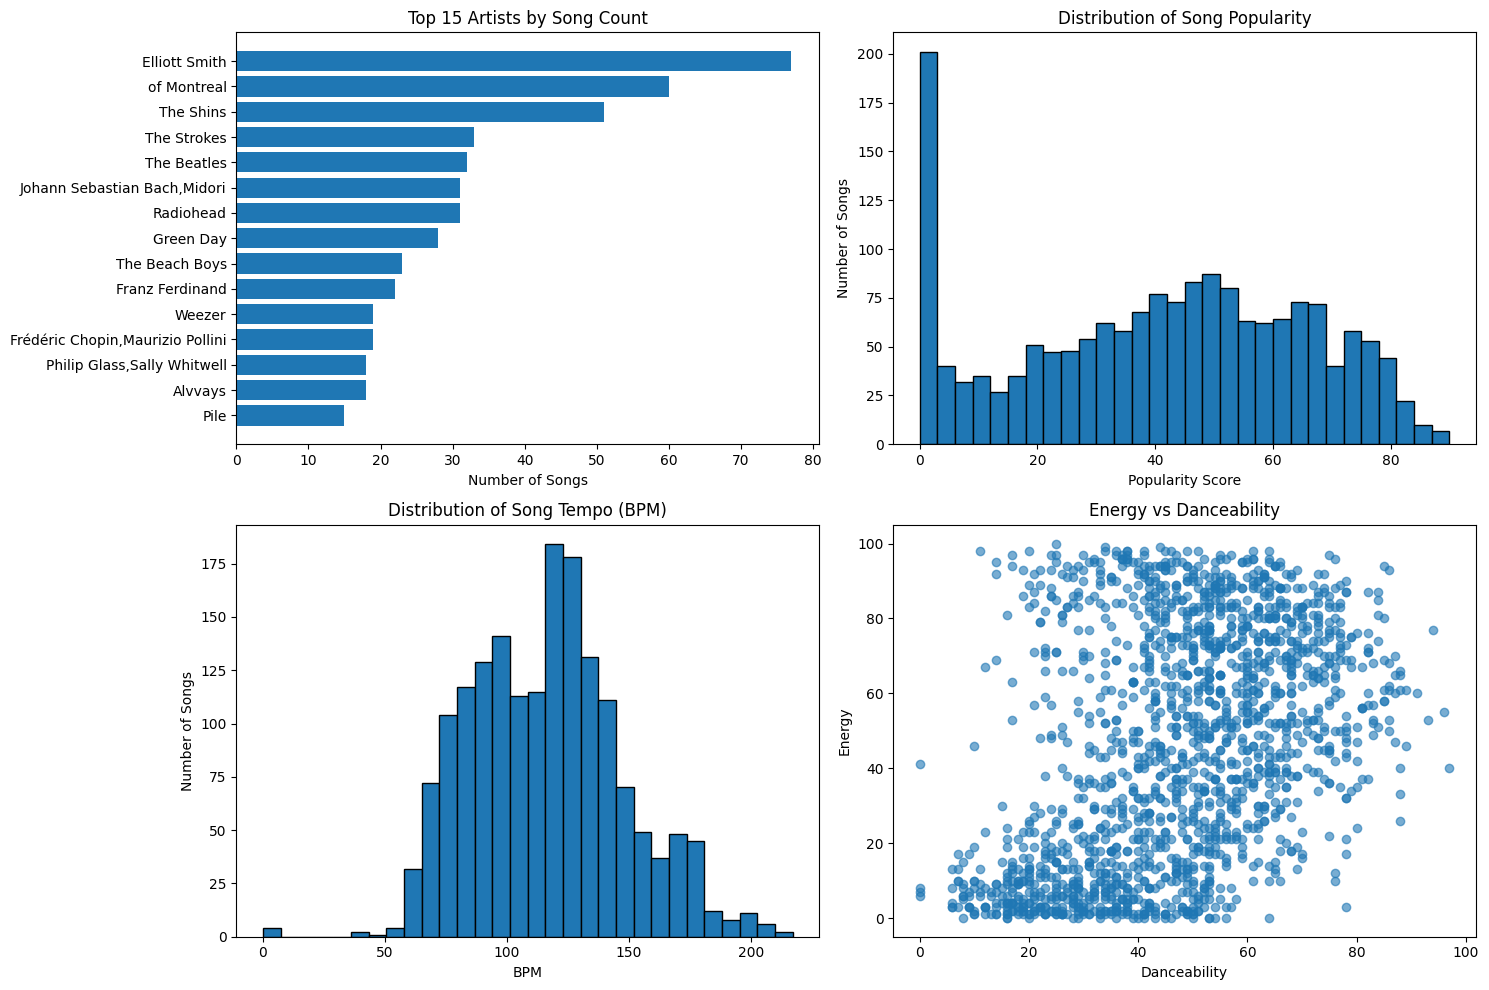

In [5]:
# Visualizations
plt.figure(figsize=(15, 10))

# Top 15 artists by song count
plt.subplot(2, 2, 1)
top_artists = df['Artist'].value_counts().head(15)
plt.barh(range(len(top_artists)), top_artists.values)
plt.yticks(range(len(top_artists)), top_artists.index)
plt.xlabel('Number of Songs')
plt.title('Top 15 Artists by Song Count')
plt.gca().invert_yaxis()

# Popularity distribution
plt.subplot(2, 2, 2)
plt.hist(df['Popularity'], bins=30, edgecolor='black')
plt.xlabel('Popularity Score')
plt.ylabel('Number of Songs')
plt.title('Distribution of Song Popularity')

# BPM distribution
plt.subplot(2, 2, 3)
plt.hist(df['BPM'], bins=30, edgecolor='black')
plt.xlabel('BPM')
plt.ylabel('Number of Songs')
plt.title('Distribution of Song Tempo (BPM)')

# Energy vs Danceability scatter
plt.subplot(2, 2, 4)
plt.scatter(df['Dance'], df['Energy'], alpha=0.6)
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.title('Energy vs Danceability')

plt.tight_layout()
plt.show()